In [53]:
#!wget https://dataworks.indianapolis.iu.edu/bitstream/handle/11243/41/data.zip
#!unzip -q data.zip
#!rm data.zip

# Imports and device settings

In [54]:
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import reduce

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset definition

## Training dataset

In [55]:
class ImageDNATrainDataset():
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1

        TRAINING_SAMPLES_NUMBER = 12481
        TRAINING_LABELS_NUMBER = 652

        assert len(train_loc[0]) == TRAINING_SAMPLES_NUMBER

        indeces = train_loc
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(
            data_mat["embeddings_img"][indeces]
        ).float()
        self.embeddings_dna = torch.from_numpy(
            data_mat["embeddings_dna"][indeces]
        ).float()

        # Remap seen species in [0, 651]
        seen_species = data_mat["labels"][train_loc][0]
        seen_species_mapping = {label: i for i, label in enumerate(np.unique(seen_species))}

        species_mapping = seen_species_mapping
        assert len(species_mapping) == TRAINING_LABELS_NUMBER

        species = data_mat["labels"][indeces]
        remapped_species = np.array([species_mapping[label.item()] for label in species])
        self.remapped_species = torch.from_numpy(remapped_species).long()

        assert len(torch.unique(self.remapped_species)) == TRAINING_LABELS_NUMBER

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(species.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[species[i][0] - 1][0] - 1041

        assert len(self.genera) == TRAINING_SAMPLES_NUMBER

        self.species_names = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        label = self.remapped_species[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera

## Validation set
- Number of samples: 6939.
- Number of seen species of the training set in the validation set: 629.
- Number of unseen species in the validation set: 97

In [56]:
class ImageDNAValidationDataset():
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1
        val_seen_loc = splits_mat["val_seen_loc"]-1
        val_unseen_loc = splits_mat["val_unseen_loc"]-1

        TRAINING_LABELS_NUMBER = 652
        VALIDATION_SAMPLES_NUMBER = 6939
        VALIDATION_SPECIES_NUMBER = 774
        TRAINING_VALIDATION_SPECIES_NUMBER = 797
        VALIDATION_SEEN_SPECIES_NUMBER = 629
        VALIDATION_UNSEEN_SPECIES_GENERA_NUMBER = 97

        indeces = np.concatenate((val_seen_loc, val_unseen_loc), axis=1)
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]
        assert len(indeces) == VALIDATION_SAMPLES_NUMBER

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(data_mat["embeddings_img"][indeces]).float()
        self.embeddings_dna = torch.from_numpy(data_mat["embeddings_dna"][indeces]).float()

        # Remap seen species in [0, 651]
        seen_species = data_mat["labels"][train_loc][0]
        seen_species_mapping = {label: i for i, label in enumerate(np.unique(seen_species))}

        # Remap unseen species during validation in [652, 796]
        unseen_species = data_mat["labels"][val_unseen_loc][0]
        unseen_species_mapping = {label: i + TRAINING_LABELS_NUMBER for i, label in enumerate(np.unique(unseen_species))}

        # Union of the two mappings, allows to fully remap all the labels
        species_mapping = seen_species_mapping | unseen_species_mapping
        assert len(species_mapping) == TRAINING_VALIDATION_SPECIES_NUMBER

        species = data_mat["labels"][indeces]
        remapped_species = np.array([species_mapping[label.item()] for label in species])
        self.remapped_species = torch.from_numpy(remapped_species).long()
        assert len(torch.unique(self.remapped_species)) == VALIDATION_SPECIES_NUMBER

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(species.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[species[i][0] - 1][0] - 1041

        # Compute genera of unseen species in the validation set
        unseen_species_genera = []
        for i in val_unseen_loc[0]:
            unseen_species_genera.append(data_mat["G"][data_mat["labels"][i][0] - 1][0] - 1041)
        self.unseen_species_genera = np.array(unseen_species_genera)
        assert len(np.unique(self.unseen_species_genera)) == VALIDATION_UNSEEN_SPECIES_GENERA_NUMBER

        # Compute seen species number in the validation set
        seen_species = []
        for i in val_seen_loc[0]:
            seen_species.append(species_mapping[data_mat["labels"][i].item()])
        self.seen_species = np.array(seen_species)
        assert len(np.unique(self.seen_species)) == VALIDATION_SEEN_SPECIES_NUMBER

        self.species_names = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        label = self.remapped_species[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera

## Test set
- Number of samples: 13428.
- Number of seen species of the training and validation set in the test set: 770.
- Number of unseen species in the test set: 134

In [57]:
class ImageDNATestDataset(Dataset):
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1
        trainval_loc = splits_mat["trainval_loc"]-1
        test_seen_loc = splits_mat["test_seen_loc"]-1
        test_unseen_loc = splits_mat["test_unseen_loc"]-1
        val_seen_loc = splits_mat["val_seen_loc"]-1
        val_unseen_loc = splits_mat["val_unseen_loc"]-1

        TRAINING_SPECIES_NUMBER = 652
        TRAINING_VALIDATION_SPECIES = 797
        NUMBER_OF_SPECIES = 1040
        TEST_SEEN_SPECIES_NUMBER = 770
        TEST_UNSEEN_SPECIES_GENERA_NUMBER = 134

        indeces = np.concatenate((test_seen_loc, test_unseen_loc), axis=1)
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(data_mat["embeddings_img"][indeces]).float()
        self.embeddings_dna = torch.from_numpy(data_mat["embeddings_dna"][indeces]).float()

        # Remap seen species in [0, 651]
        seen_species = data_mat["labels"][train_loc][0]
        seen_species_mapping = {label: i for i, label in enumerate(np.unique(seen_species))}

        # Remap unseen species during validation in [652, 796]
        unseen_species_validation = data_mat["labels"][val_unseen_loc][0]
        unseen_species_validation_mapping = {label: i + TRAINING_SPECIES_NUMBER for i, label in enumerate(np.unique(unseen_species_validation))}

        # Remap unseen species during test in [797, 1039]
        unseen_species_test = data_mat["labels"][test_unseen_loc][0]
        unseen_species_test_mapping = {label: i + TRAINING_VALIDATION_SPECIES for i, label in enumerate(np.unique(unseen_species_test))}

        assert reduce(np.intersect1d, (seen_species, unseen_species_validation, unseen_species_test)).size == 0

        # Union of the two mappings, allows to full remap all the labels
        labels_mapping = seen_species_mapping | unseen_species_validation_mapping | unseen_species_test_mapping
        assert len(labels_mapping) == NUMBER_OF_SPECIES

        species = data_mat["labels"][indeces]
        remapped_labels = np.array([labels_mapping[label.item()] for label in species])
        self.remapped_labels = torch.from_numpy(remapped_labels).long()

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(species.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[species[i][0] - 1][0] - 1041

        # Compute genera of unseen species
        unseen_species_genera = []
        for i in test_unseen_loc[0]:
            unseen_species_genera.append(data_mat["G"][data_mat["labels"][i][0] - 1][0] - 1041)

        self.unseen_species_genera = np.array(unseen_species_genera)
        assert len(np.unique(self.unseen_species_genera)) == TEST_UNSEEN_SPECIES_GENERA_NUMBER

        # Compute seen species
        seen_species = []
        for i in test_seen_loc[0]:
            seen_species.append(labels_mapping[data_mat["labels"][i].item()])
        self.seen_species = np.array(seen_species)
        assert len(np.unique(self.seen_species)) == TEST_SEEN_SPECIES_NUMBER

        self.species_name = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        label = self.remapped_labels[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera

## Training and validation dataset

In [58]:
class ImageDNATrainValidationDataset(Dataset):
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1
        trainval_loc = splits_mat["trainval_loc"]-1
        test_seen_loc = splits_mat["test_seen_loc"]-1
        test_unseen_loc = splits_mat["test_unseen_loc"]-1
        val_seen_loc = splits_mat["val_seen_loc"]-1
        val_unseen_loc = splits_mat["val_unseen_loc"]-1

        TRAINING_SPECIES_NUMBER = 652
        TRAINING_VALIDATION_SPECIES = 797
        NUMBER_OF_SPECIES = 1040

        indeces = trainval_loc
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(data_mat["embeddings_img"][indeces]).float()
        self.embeddings_dna = torch.from_numpy(data_mat["embeddings_dna"][indeces]).float()

        # Remap seen species in [0, 651]
        seen_species = data_mat["labels"][train_loc][0]
        seen_species_mapping = {label: i for i, label in enumerate(np.unique(seen_species))}

        # Remap unseen species during validation in [652, 796]
        unseen_species_validation = data_mat["labels"][val_unseen_loc][0]
        unseen_species_validation_mapping = {label: i + TRAINING_SPECIES_NUMBER for i, label in enumerate(np.unique(unseen_species_validation))}

        # Remap unseen species during test in [797, 1039]
        unseen_species_test = data_mat["labels"][test_unseen_loc][0]
        unseen_species_test_mapping = {label: i + TRAINING_VALIDATION_SPECIES for i, label in enumerate(np.unique(unseen_species_test))}

        assert reduce(np.intersect1d, (seen_species, unseen_species_validation, unseen_species_test)).size == 0

        # Union of the two mappings, allows to full remap all the labels
        labels_mapping = seen_species_mapping | unseen_species_validation_mapping | unseen_species_test_mapping
        assert len(labels_mapping) == NUMBER_OF_SPECIES

        species = data_mat["labels"][indeces]  # Consider only train
        remapped_labels = np.array([labels_mapping[label.item()] for label in species])
        self.remapped_labels = torch.from_numpy(remapped_labels).long()

        assert len(torch.unique(self.remapped_labels)) == TRAINING_VALIDATION_SPECIES

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(species.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[species[i][0] - 1][0] - 1041

        self.species = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        label = self.remapped_labels[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera


# Model definition

In [59]:
class AttentionNet(nn.Module):
        def __init__(self, num_seen_species, num_genera):
                super(AttentionNet, self).__init__()
                self.img_fc1 = nn.Linear(2048, 512)

                self.dna_fc1 = nn.Linear(500, 512)

                self.img_dna_encoder_1 = ImageDNASlimEncoder(512, 2)
                self.img_dna_encoder_2 = ImageDNASlimEncoder(512, 2)

                self.fc_species_1 = nn.Linear(1024, num_seen_species)
                self.fc_genera_1 = nn.Linear(1024, num_genera)

                self.dropout = nn.Dropout(0.5)


        def forward(self, x_img, x_dna):
                x_img = self.img_fc1(x_img)
                x_dna = self.dna_fc1(x_dna)

                x_img, x_dna = self.img_dna_encoder_1(x_img, x_dna)
                x_img, x_dna = F.gelu(x_img), F.gelu(x_dna)
                x_img, x_dna = self.img_dna_encoder_2(x_img, x_dna)

                x = torch.cat((x_img, x_dna), axis=2)
                x = torch.squeeze(x, dim=1)

                x_species = self.fc_species_1(x)
                x_genera = self.fc_genera_1(x)

                return x_species, x_genera

class ImageDNASlimEncoder(nn.Module):
        def __init__(self, embed_dim, num_heads):
                super(ImageDNASlimEncoder, self).__init__()
                self.multi_head_img_1 = nn.MultiheadAttention(embed_dim, num_heads)
                self.multi_head_dna_1 = nn.MultiheadAttention(embed_dim, num_heads)

                self.norm_img_1 = nn.LayerNorm(embed_dim)
                self.norm_dna_1 = nn.LayerNorm(embed_dim)


        def forward(self, x_img, x_dna):
                identity = x_img
                x_img_out, _ = self.multi_head_img_1(x_img, x_dna, x_dna)
                x_img_out = self.norm_img_1(x_img_out + identity)

                identity = x_dna
                x_dna_out, _ = self.multi_head_dna_1(x_dna, x_img, x_img)
                x_dna_out = self.norm_dna_1(x_dna_out + identity)

                return x_img_out, x_dna_out

# Creating datasets

In [60]:
training_set = ImageDNATrainDataset()
validation_set = ImageDNAValidationDataset()
test_set = ImageDNATestDataset()
training_validation_set = ImageDNATrainValidationDataset()

Defining methods for training, validating and testing the model.

# Training, validation and testing

## Validation
Returns the described validation accuracy by species and the undescribed validation accuracy by genus.

In [61]:
def validate(model, threshold, batch_size):

    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)
    model.eval()

    with torch.no_grad():
        correct_predictions_per_labels = defaultdict(int)
        total_samples_per_labels = defaultdict(int)
        correct_predictions_per_genera = defaultdict(int)
        total_samples_per_genera = defaultdict(int)

        for data in validation_loader:
            inputs_img, inputs_dna, species, genera = data
            inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

            labels_outputs, genera_outputs = model(inputs_img, inputs_dna)

            labels_outputs = nn.Softmax(dim=1)(labels_outputs)
            genera_outputs = nn.Softmax(dim=1)(genera_outputs)

            predicted_labels_values, predicted_labels = torch.topk(labels_outputs.data, k=2, dim=1)
            _, predicted_genera = torch.max(genera_outputs.data, 1)

            differences = predicted_labels_values[:, 0] - predicted_labels_values[:, 1]
            genera_mask = differences <= threshold
            labels_mask = ~genera_mask

            # Update relative frequencies
            for idx in range(len(genera)):
                total_samples_per_labels[species[idx].item()] += 1

                if labels_mask[idx] and predicted_labels[idx, 0] == species[idx]:
                    correct_predictions_per_labels[species[idx].item()] += 1

                # if the sample is of one undescribed species
                if species[idx].item() not in np.unique(validation_set.seen_species):
                    assert genera[idx].item() in np.unique(validation_set.unseen_species_genera)
                    total_samples_per_genera[genera[idx].item()] += 1

                    if genera_mask[idx] and predicted_genera[idx] == genera[idx]:
                        correct_predictions_per_genera[genera[idx].item()] += 1

        accuracy_per_label = {label: (correct_predictions_per_labels[label] / total_samples_per_labels[label]) if total_samples_per_labels[label] > 0 else 0 for label in total_samples_per_labels}
        accuracy_per_genera = {genera: (correct_predictions_per_genera[genera] / total_samples_per_genera[genera]) if total_samples_per_genera[genera] > 0 else 0 for genera in total_samples_per_genera}

        test_described_species_accuracy = 0
        for label in np.unique(validation_set.seen_species):
            test_described_species_accuracy += accuracy_per_label[label]

        test_undescribed_species_accuracy = 0
        for genera in np.unique(validation_set.unseen_species_genera):
            test_undescribed_species_accuracy += accuracy_per_genera[genera]

        normalized_test_described_species_accuracy = test_described_species_accuracy / 629
        normalized_test_undescribed_species_accuracy = test_undescribed_species_accuracy / 97

        return normalized_test_described_species_accuracy, normalized_test_undescribed_species_accuracy

## Validation genera loss
Computes the validation genera loss of the model.

In [62]:
def validate_loss(model, batch_size):
        criterion_species = torch.nn.CrossEntropyLoss()
        criterion_genera = torch.nn.CrossEntropyLoss()
        validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)
        model.eval()
        validation_genera_loss = 0.0
        validation_species_loss = 0.0
        with torch.no_grad():
            seen_species_samples_count = 0
            for data in validation_loader:
                inputs_img, inputs_dna, species, genera = data
                inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

                # Genera loss
                _, genera_outputs = model(inputs_img, inputs_dna)
                validation_genera_loss += criterion_genera(genera_outputs, genera).item() * inputs_img.size(0)

                # Species loss
                seen_mask = species < 652
                seen_inputs_img = inputs_img[seen_mask]
                seen_inputs_dna = inputs_dna[seen_mask]
                seen_species = species[seen_mask]
                seen_genera = genera[seen_mask]
                seen_species_samples_count += seen_inputs_img.size(0)
                seen_species_outputs, _ = model(seen_inputs_img, seen_inputs_dna)
                validation_species_loss += criterion_species(seen_species_outputs, seen_species).item() * seen_inputs_img.size(0)

        validation_genera_loss = validation_genera_loss / len(validation_loader.dataset)
        validation_species_loss = validation_species_loss / seen_species_samples_count
        return validation_species_loss, validation_genera_loss

## Test
Returns the described test accuracy by species and the undescribed validation accuracy by genus.

In [63]:
def test(model, threshold, batch_size):
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    model.eval()

    with torch.no_grad():
        correct_predictions_per_labels = defaultdict(int)
        total_samples_per_labels = defaultdict(int)
        correct_predictions_per_genera = defaultdict(int)
        total_samples_per_genera = defaultdict(int)

        for data in test_loader:
            inputs_img, inputs_dna, species, genera = data
            inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

            labels_outputs, genera_outputs = model(inputs_img, inputs_dna)

            labels_outputs = nn.Softmax(dim=1)(labels_outputs)
            genera_outputs = nn.Softmax(dim=1)(genera_outputs)

            predicted_labels_values, predicted_labels = torch.topk(labels_outputs.data, k=2, dim=1)
            _, predicted_genera = torch.max(genera_outputs.data, 1)

            differences = predicted_labels_values[:, 0] - predicted_labels_values[:, 1]
            genera_mask = differences <= threshold
            labels_mask = ~genera_mask

            # Update relative frequencies
            for idx in range(len(genera)):
                total_samples_per_labels[species[idx].item()] += 1

                if labels_mask[idx] and predicted_labels[idx, 0] == species[idx]:
                    correct_predictions_per_labels[species[idx].item()] += 1

                # if the sample is of one undescribed species
                if species[idx].item() not in np.unique(test_set.seen_species):
                    assert genera[idx].item() in np.unique(test_set.unseen_species_genera)
                    total_samples_per_genera[genera[idx].item()] += 1

                    if genera_mask[idx] and predicted_genera[idx] == genera[idx]:
                        correct_predictions_per_genera[genera[idx].item()] += 1

        accuracy_per_label = {label: (correct_predictions_per_labels[label] / total_samples_per_labels[label]) if total_samples_per_labels[label] > 0 else 0 for label in total_samples_per_labels}
        accuracy_per_genera = {genera: (correct_predictions_per_genera[genera] / total_samples_per_genera[genera]) if total_samples_per_genera[genera] > 0 else 0 for genera in total_samples_per_genera}

        test_described_species_accuracy = 0
        for label in np.unique(test_set.seen_species):
            test_described_species_accuracy += accuracy_per_label[label]

        test_undescribed_species_accuracy = 0
        for genera in np.unique(test_set.unseen_species_genera):
            test_undescribed_species_accuracy += accuracy_per_genera[genera]

        normalized_test_described_species_accuracy = test_described_species_accuracy / 770
        normalized_test_undescribed_species_accuracy = test_undescribed_species_accuracy / 134

        return normalized_test_described_species_accuracy, normalized_test_undescribed_species_accuracy

## Training
Trains the model on the training split with early stopping. Returns the genera loss of the model at the end of the training.

In [64]:
def train(model, lr, momentum, max_epochs, batch_size, print_losses=False, print_step=200):
    model.train()
    criterion_species = torch.nn.CrossEntropyLoss()
    criterion_genera = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50)

    # Variables for early stopping
    validation_species_loss = 0
    validation_genera_loss = 0
    training_species_loss = 0
    training_genera_loss = 0
    best_validation_loss = np.inf
    optimal_training_epochs = max_epochs

    for epoch in range(max_epochs):
        model.train()
        running_species_loss = 0.0
        running_genera_loss = 0.0

        for i, data in enumerate(loader, 0):
            inputs_img, inputs_dna, species, genera = data
            inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            species_outputs, genera_outputs = model(inputs_img, inputs_dna)
            labels_loss = criterion_species(species_outputs, species)
            genera_loss = criterion_genera(genera_outputs, genera)
            total_loss = labels_loss + genera_loss
            total_loss.backward()
            optimizer.step()
            scheduler.step()

            # Print losses
            if print_losses:
                running_species_loss += labels_loss.item()
                running_genera_loss += genera_loss.item()
                if i % print_step == print_step - 1:
                    print(f"[{epoch + 1}, {i + 1:5d}] Species loss: {running_species_loss / print_step:.3f}; Genera loss: {running_genera_loss / print_step:.3f}")
                    training_species_loss = running_species_loss / print_step
                    training_genera_loss = running_genera_loss / print_step
                    running_species_loss = 0.0
                    running_genera_loss = 0.0

        # Early stopping
        patience = 20
        validation_species_loss, validation_genera_loss = validate_loss(model, batch_size)
        validation_loss = validation_species_loss + validation_genera_loss
        print(f"Validation genera loss at epoch {epoch+1}: {validation_genera_loss}")
        print(f"Validation species loss at epoch {epoch+1}: {validation_species_loss}")
        print(f"Validation loss at epoch {epoch+1}: {validation_loss}")

        # Check if validation loss improved
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            optimal_training_epochs = epoch + 1
            break

    model.load_state_dict(torch.load('best_model.pth'))
    return training_species_loss + training_genera_loss

Trains the model on the training and validation split. The training stops when the genera loss over the validation set is less than the training genera loss computed beforehand. This procedure is the one desribed in the Deep Learning Book (Goodfellow et. al, 2016) at Section 7.3.

In [65]:
def train_final(model, lr, momentum, max_epochs, batch_size, training_loss, print_losses=False, print_step=200):
    model.train()
    criterion_species = torch.nn.CrossEntropyLoss()
    criterion_genera = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    training_validation_loader = torch.utils.data.DataLoader(training_validation_set, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50)

    validation_genera_loss = 0

    for epoch in range(max_epochs):
        model.train()
        running_labels_loss = 0.0
        running_genera_loss = 0.0

        for i, data in enumerate(training_validation_loader, 0):
            inputs_img, inputs_dna, species, genera = data
            inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            species_outputs, genera_outputs = model(inputs_img, inputs_dna)
            labels_loss = criterion_species(species_outputs, species)
            genera_loss = criterion_genera(genera_outputs, genera)
            total_loss = labels_loss + genera_loss
            total_loss.backward()
            optimizer.step()
            scheduler.step()

            # Print losses
            if print_losses:
                running_labels_loss += labels_loss.item()
                running_genera_loss += genera_loss.item()
                if i % print_step == print_step - 1:
                    print(f"[{epoch + 1}, {i + 1:5d}] Species loss: {running_labels_loss / print_step:.3f}; Genera loss: {running_genera_loss / print_step:.3f}")
                    running_labels_loss = 0.0
                    running_genera_loss = 0.0

        validation_species_loss, validation_genera_loss = validate_loss(model, batch_size)
        validation_loss = validation_species_loss + validation_genera_loss
        print(f"Validation loss at epoch {epoch+1}: {validation_loss}")

        if validation_loss < training_loss:
            print(f"Interrupted final training at epoch {epoch+1}")
            break

    return None

# Model selection
We tune the threshold through model selection:

In [66]:
lr = 0.01
threshold_values = np.linspace(0.7, 0.99, 60)
momentum = 0.9
batch_size = 512
max_epochs = 1500

best_validation_accuracy = 0
best_threshold = 0

model = AttentionNet(652, 368)
model.to(device)
training_loss = train(model, lr, momentum, max_epochs, batch_size, print_losses=True, print_step=10)
for threshold in threshold_values:
    validation_species_accuracy, validation_genera_accuracy = validate(model, threshold, batch_size)
    validation_loss = validation_species_accuracy + validation_genera_accuracy
    print((f"Validation accuracy: {validation_loss} for threshold={threshold}, "))

    if validation_loss > best_validation_accuracy:
        best_validation_accuracy = validation_loss
        best_threshold = threshold

print("Best threshold:", best_threshold)

Streaming output truncated to the last 5000 lines.
[513,    20] Species loss: 0.001; Genera loss: 0.001
Validation genera loss at epoch 513: 0.43503300639682485
Validation species loss at epoch 513: 0.022768046418425534
Validation loss at epoch 513: 0.4578010528152504
[514,    10] Species loss: 0.001; Genera loss: 0.001
[514,    20] Species loss: 0.001; Genera loss: 0.001
Validation genera loss at epoch 514: 0.43496546860060065
Validation species loss at epoch 514: 0.02273356006865183
Validation loss at epoch 514: 0.4576990286692525
[515,    10] Species loss: 0.001; Genera loss: 0.001
[515,    20] Species loss: 0.001; Genera loss: 0.001
Validation genera loss at epoch 515: 0.4350518511409872
Validation species loss at epoch 515: 0.022591916934673308
Validation loss at epoch 515: 0.45764376807566054
[516,    10] Species loss: 0.001; Genera loss: 0.001
[516,    20] Species loss: 0.001; Genera loss: 0.001
Validation genera loss at epoch 516: 0.43488950414725625
Validation species loss at 

# Final model training
We select the best parameters found in the model selection section to train the final model on training and validation set.
The model is then tested on the test set, which has 797 seen species.

In [67]:
model = AttentionNet(797, 368)
model.to(device)

print(f"Training genera loss: {training_loss}")
state_dict = torch.load('best_model.pth')
state_dict = {k: v for k, v in state_dict.items() if not (k.startswith('fc_species_1') or k.startswith('fc_genera_1') or k.startswith('fc_species_2') or k.startswith('fc_genera_2'))}
model.load_state_dict(state_dict, strict=False)

train_final(model, lr, momentum, max_epochs, batch_size, training_loss, print_losses=True, print_step=10)

Streaming output truncated to the last 5000 lines.
[81,    20] Species loss: 0.006; Genera loss: 0.003
[81,    30] Species loss: 0.006; Genera loss: 0.004
Validation loss at epoch 81: 0.012688118971511017
[82,    10] Species loss: 0.006; Genera loss: 0.003
[82,    20] Species loss: 0.006; Genera loss: 0.003
[82,    30] Species loss: 0.006; Genera loss: 0.003
Validation loss at epoch 82: 0.012529816632608964
[83,    10] Species loss: 0.006; Genera loss: 0.003
[83,    20] Species loss: 0.006; Genera loss: 0.003
[83,    30] Species loss: 0.006; Genera loss: 0.003
Validation loss at epoch 83: 0.012405179018801636
[84,    10] Species loss: 0.006; Genera loss: 0.003
[84,    20] Species loss: 0.006; Genera loss: 0.003
[84,    30] Species loss: 0.006; Genera loss: 0.003
Validation loss at epoch 84: 0.012209465793042978
[85,    10] Species loss: 0.006; Genera loss: 0.003
[85,    20] Species loss: 0.006; Genera loss: 0.003
[85,    30] Species loss: 0.006; Genera loss: 0.003
Validation loss at ep

In [68]:
species_accuracy, genera_accuracy = test(model, best_threshold, batch_size)

print("-------------------------------------------------------------------------------")
print(f"Final model described species accuracy: ", species_accuracy)
print(f"Final model undescribed species accuracy: ", genera_accuracy)
print("-------------------------------------------------------------------------------")

-------------------------------------------------------------------------------
Final model described species accuracy:  0.9852260663218453
Final model undescribed species accuracy:  0.7805970167344355
-------------------------------------------------------------------------------


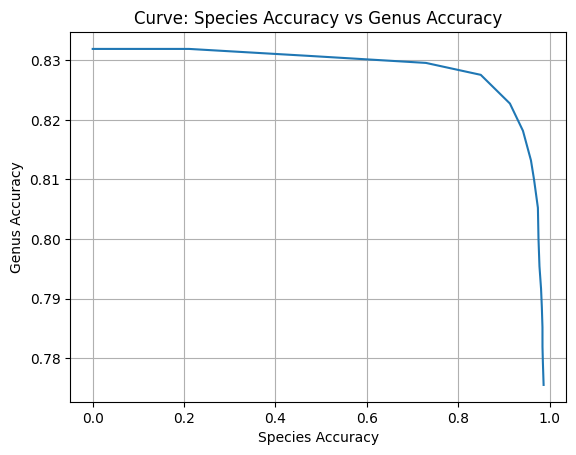

In [71]:
species_accuracies = []
genus_accuracies = []

linear_space = np.linspace(0, 1, 20)
condensed_space = 1 - (1 - linear_space) ** 3
threshold_values = 0.9 + 0.1 * condensed_space

for threshold in threshold_values:
    species_accuracy, genus_accuracy = test(model, threshold, batch_size)
    species_accuracies.append(species_accuracy)
    genus_accuracies.append(genus_accuracy)

# Plotting the curve
plt.plot(species_accuracies, genus_accuracies, marker=' ')
plt.xlabel('Species Accuracy')
plt.ylabel('Genus Accuracy')
plt.title('Curve: Species Accuracy vs Genus Accuracy')
plt.grid(True)
plt.show()

In [70]:
only_species_accuracy, _ = test(model, 0, batch_size)
_, only_genera_accuracy = test(model, 1, batch_size)

print("-------------------------------------------------------------------------------")
print(f"Final model only described species accuracy: ", only_species_accuracy)
print(f"Final model only undescribed species accuracy: ", only_genera_accuracy)
print("-------------------------------------------------------------------------------")

-------------------------------------------------------------------------------
Final model only described species accuracy:  0.9939493145743145
Final model only undescribed species accuracy:  0.8318949689578551
-------------------------------------------------------------------------------
